In [1]:
# MERGE ALL TEMP .H5 FILES INTO A SINGLE FINAL FILE


import csv, ast, os
from collections import defaultdict
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor
import pandas as pd

# === Step 6: Patch to merge all .h5 files ===
def merge_all_hdf5_files(final_file="final_tick_data.h5"):
    temp_files = [f for f in os.listdir(".") if f.endswith(".h5") and f != final_file]
    with pd.HDFStore(final_file, mode='a') as final_store:
        for temp in temp_files:
            try:
                with pd.HDFStore(temp, mode='r') as temp_store:
                    keys = temp_store.keys()
                    if not keys:
                        print(f"⚠️ Skipping empty file: {temp}")
                        continue
                    for key in keys:
                        df = temp_store[key]
                        final_store.put(key, df, format='table', data_columns=True)
            except Exception as e:
                print(f"❌ Error reading {temp}: {e}")
            finally:
                try:
                    os.remove(temp)
                    print(f"🗑️ Deleted temp file: {temp}")
                except Exception as e:
                    print(f"⚠️ Could not delete {temp}: {e}")

merge_all_hdf5_files()

🗑️ Deleted temp file: temp_worker_1.h5
🗑️ Deleted temp file: temp_worker_16.h5
🗑️ Deleted temp file: temp_worker_5.h5
🗑️ Deleted temp file: temp_worker_9.h5


In [2]:
# DECOMPOSE FINAL FILE BY INSTRUMENT


import csv, ast, os
from collections import defaultdict
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor
import pandas as pd

def decompose_by_instrument(final_file, output_dir="split_by_instrument"):
    os.makedirs(output_dir, exist_ok=True)
    with pd.HDFStore(final_file, mode='r') as store:
        keys = store.keys()
        instrument_groups = defaultdict(list)
        for key in keys:
            instrument = key.strip("/").split("/")[0]
            instrument_groups[instrument].append(key)

        for instrument, group_keys in instrument_groups.items():
            out_path = os.path.join(output_dir, f"{instrument}_tick_data.h5")
            with pd.HDFStore(out_path, mode='w') as out_store:
                for key in group_keys:
                    df = store[key]
                    out_store.put(key, df, format='table', data_columns=True)

decompose_by_instrument("final_tick_data.h5")
print("✅ All tasks complete. Data split by instrument.")

✅ All tasks complete. Data split by instrument.


In [3]:
# MERGE TO RAW FILES

import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

def merge_instrument_file(instrument, fetched_dir="split_by_instrument", raw_dir="./2015_tick_data"):
    fetched_path = os.path.join(fetched_dir, f"{instrument}_tick_data.h5")
    raw_path = os.path.join(raw_dir, f"{instrument}_tick_data.h5")

    if not os.path.exists(fetched_path):
        print(f"⚠️ Fetched file missing: {instrument}")
        return
    if not os.path.exists(raw_path):
        print(f"⚠️ Raw file missing: {instrument}")
        return

    with pd.HDFStore(raw_path, mode='a') as raw_store, pd.HDFStore(fetched_path, mode='r') as fetched_store:
        for key in fetched_store.keys():
            if key in raw_store:
                print(f"🔁 Skipping duplicate key: {key} in {instrument}")
                continue
            df = fetched_store[key]
            raw_store.put(key, df, format='table', data_columns=True)

    print(f"✅ Merged fetched → raw: {instrument}")

def main():
    fetched_dir = "split_by_instrument"     # Correct folder for fetched files
    raw_dir = "./2015_tick_data"            # Correct folder for raw files

    # Get list of instruments based on fetched files
    instruments = [
        filename.replace("_tick_data.h5", "")
        for filename in os.listdir(fetched_dir)
        if filename.endswith("_tick_data.h5")
    ]

    # Run merge in parallel
    with ThreadPoolExecutor(max_workers=32) as executor:
        for instrument in instruments:
            executor.submit(merge_instrument_file, instrument, fetched_dir, raw_dir)

if __name__ == "__main__":
    main()

✅ Merged fetched → raw: hkgidxhkd
✅ Merged fetched → raw: lightcmdusd
✅ Merged fetched → raw: usa30idxusd
✅ Merged fetched → raw: usatechidxusd


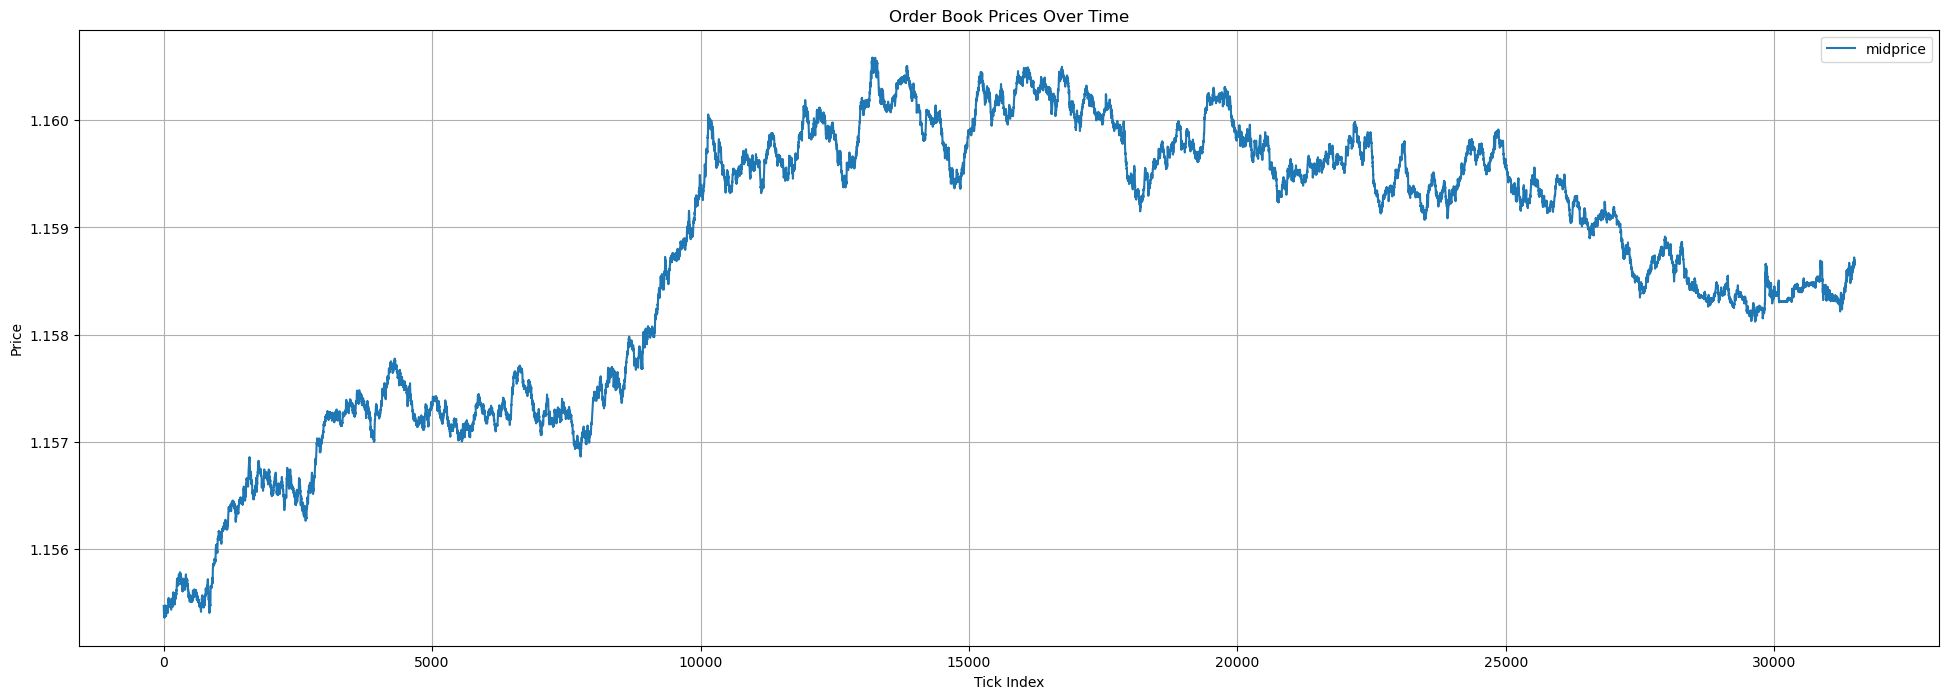

In [190]:
# LOAD HDF5 FILE TO VERIFY
import pandas as pd

instrument = "eurusd"  # Replace with your desired instrument

# Load the HDF5 file
store = pd.HDFStore(f'2015_tick_data/{instrument}_tick_data.h5')  # Replace with your actual file path
df = store[f'{instrument}/y2025/m11/d11']
store.close()

df['imbalance'] = (df['bidVolume'] - df['askVolume']) / (df['bidVolume'] + df['askVolume'])

df['midprice'] = (df['bidPrice'] + df['askPrice']) / 2
df['spread'] = df['askPrice'] - df['bidPrice']

df.head()

import matplotlib.pyplot as plt

columns_to_plot = ['midprice']  # Add more columns if needed
df[columns_to_plot].plot(title='Order Book Prices Over Time', figsize=(24, 8))

plt.xlabel('Tick Index')
plt.ylabel('Price')
plt.grid(True)
plt.legend(loc='best')  # Optional: show legend
plt.show()


In [191]:
df['imbalance'].describe()

count    31500.000000
mean         0.011269
std          0.382115
min         -0.974922
25%         -0.295499
50%          0.000000
75%          0.333333
max          0.976744
Name: imbalance, dtype: float64

In [192]:
negative_imbalance_count = (df['imbalance'] < 0).sum()
positive_imbalance_count = (df['imbalance'] > 0).sum()
print(f"Number of negative values in 'imbalance': {negative_imbalance_count} \nNumber of positive values in 'imbalance': {positive_imbalance_count}")

Number of negative values in 'imbalance': 10653 
Number of positive values in 'imbalance': 11398


In [193]:
negative_imbalance_sum = df.loc[df['imbalance'] < 0, 'imbalance'].sum()
positive_imbalance_sum = df.loc[df['imbalance'] > 0, 'imbalance'].sum()

print(f"Sum of negative imbalance: {negative_imbalance_sum}")
print(f"Sum of positive imbalance: {positive_imbalance_sum}")

Sum of negative imbalance: -4340.248798035234
Sum of positive imbalance: 4695.216584139122


In [194]:
difference = negative_imbalance_sum + positive_imbalance_sum
print(f"Difference of absolute values: {difference}")

Difference of absolute values: 354.9677861038872


In [4]:
import pandas as pd

instrument = "eurusd"
year = "2025"
month = "10"
results = []

with pd.HDFStore(f'2015_tick_data/{instrument}_tick_data.h5', mode='r') as store:
    for day in range(1, 32):
        day_key = f'/{instrument}/y{year}/m{month}/d{day:02d}'
        if day_key in store.keys():
            df_day = store[day_key]

            if df_day.empty:
                print(f"{day_key} is empty — skipping.")
                continue

            required_cols = {'bidVolume', 'askVolume', 'bidPrice', 'askPrice'}
            if not required_cols.issubset(df_day.columns):
                print(f"{day_key} missing columns: {df_day.columns}")
                continue

            df_day['imbalance'] = (df_day['bidVolume'] - df_day['askVolume']) / (df_day['bidVolume'] + df_day['askVolume'])
            df_day['midprice'] = (df_day['bidPrice'] + df_day['askPrice']) / 2
            df_day['spread'] = df_day['askPrice'] - df_day['bidPrice']

            negative_count = (df_day['imbalance'] < 0).sum()
            positive_count = (df_day['imbalance'] > 0).sum()
            negative_sum = df_day.loc[df_day['imbalance'] < 0, 'imbalance'].sum()
            positive_sum = df_day.loc[df_day['imbalance'] > 0, 'imbalance'].sum()
            difference = negative_sum + positive_sum

            results.append({
                'day': day,
                'negative_count': negative_count,
                'positive_count': positive_count,
                'negative_sum': negative_sum,
                'positive_sum': positive_sum,
                'difference': difference
            })
        else:
            print(f"{day_key} not found.")

# Final check
if not results:
    print("No valid data found for any day in October.")

summary_df = pd.DataFrame(results)


/eurusd/y2025/m10/d04 not found.
/eurusd/y2025/m10/d11 not found.
/eurusd/y2025/m10/d18 not found.
/eurusd/y2025/m10/d25 not found.


In [5]:
with pd.HDFStore(f'2015_tick_data/{instrument}_tick_data.h5', mode='a') as store:
    summary_key = f'/{instrument}/y{year}/m{month}/summary_volume_imbalance'
    store.put(summary_key, summary_df, format='table', data_columns=True)

print(f"✅ Summary DataFrame saved to {summary_key}")

✅ Summary DataFrame saved to /eurusd/y2025/m10/summary_volume_imbalance
